# Section 4: Human-in-the-Loop with LangGraph Primitives

In Section 3, we built a supervisor using `create_agent` that routes queries to specialized sub-agents. However, to handle some queries like _"Whats the status of my recent order?"_, we need to first verify the customer's identity **before** the agent can provide support.

<div align="center">
    <img src="../../static/supervisor_with_verification.png" width="800">
</div>

In this section, we'll add a **verification layer** to our agent using LangGraph primitives that:
- Classifies whether a query needs identity verification
- Pauses execution to collect customer email (HITL)
- Validates the email against our customer database
- Skips verification on follow-up questions in the same thread
- Routes to our Supervisor Agent for the actual query handling

We keep the sub-agents simple (`create_agent`), but add more complex orchestration with LangGraph.

### Setup

Load environment variables and necessary imports.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## Build Verification Layer with LangGraph Primitives

Now we'll add a verification layer that sits **in front of** the supervisor. To do so, we'll need to:
1. Define a custom state schema that stores a `customer_id` once verified
2. Build a set of nodes and edges that implement our verification and routing logic
3. Compile our state + nodes + supervisor agent into a graph that we can invoke

### State Schema

Since we'll now be collecting and storing information about the customer, we need to make sure this information is persisted in our graph's state.

We'll extend LangChain's `AgentState` to include a `customer_id`, so this value will be shared across the verification layer, supervisor, and sub-agents.

In [2]:
from langchain.agents import AgentState


class CustomState(AgentState):
    """Extended AgentState with customer_id

    AgentState includes a `messages` key with proper reducers by default.
    Shared keys automatically flow between parent and subgraphs.
    """

    customer_id: str

### Define Graph Nodes

We'll create 4 nodes:
1. **query_router**: Classifies whether a query needs identity verification before answering
2. **verify_customer**: Ensures the agent has a valid `customer_id` based on provided email address
3. **collect_email**: Dedicated HITL node that pauses with `interrupt()` to collect user input
4. **supervisor_agent (subgraph)**: The supervisor agent that handles the actual query

#### Node 1: Query Router

The "Query Router" node makes a decision about whether identity verification is required to answer the user's question.

It inspects the agent's state and the user's latest message to determine:
1. If the customer should be prompted for verification (such as when asking for information about a particular order), or 
2. If the request can proceed directly to the supervisor agent (for general questions or public information)


##### Helper Function

We'll use an LLM with structured output to classify each user message to determine if it requires verification, so lets set that up first.

In [3]:
import pprint
from typing_extensions import TypedDict, Annotated
from langchain.chat_models import init_chat_model
from config import DEFAULT_MODEL


# TypedDict for structured LLM output
class QueryClassification(TypedDict):
    """Classification of whether customer identity verification is required."""

    reasoning: Annotated[
        str, ..., "Brief explanation of why verification is or isn't needed"
    ]
    requires_verification: Annotated[
        bool,
        ...,
        "True if the query requires knowing customer identity (e.g., 'my orders', 'my account', 'my purchases'). False for general questions (product info, policies, how-to questions).",
    ]


def classify_query_intent(query: str) -> QueryClassification:
    """Classify whether a query requires customer identity verification.

    Args:
        query: The user's query string

    Returns:
        QueryClassification dict with reasoning and requires_verification fields
    """
    llm = init_chat_model(DEFAULT_MODEL)

    # Create structured LLM
    structured_llm = llm.with_structured_output(QueryClassification)
    classification_prompt = """Analyze the user's query to determine if it requires knowing their customer identity in order to answer the question."""

    # Get structured classification
    classification = structured_llm.invoke(
        [
            {"role": "system", "content": classification_prompt},
            {"role": "user", "content": "Query: " + query},
        ]
    )

    return classification

In [4]:
test = classify_query_intent("Whats the status of my recent order?")
pprint.pprint(test)

{'reasoning': 'This query asks about "my recent order," which requires knowing '
              "the customer's identity and their personal order history. "
              'Without verifying who the customer is, we cannot retrieve their '
              'specific order information.',
 'requires_verification': True}


##### Node Implementation

Now, we can leverage this `classify_query_intent` function in a node to intelligently decide when to route users for identity verification vs. letting them skip directly to the supervisor agent for general questions.

In [5]:
from langgraph.types import Command
from typing import Literal


# Node 1: Query Router
def query_router(
    state: CustomState,
) -> Command[Literal["verify_customer", "supervisor_agent"]]:
    """Route query based on verification needs.

    Logic:
    1. If customer already verified from earlier in the thread → supervisor_agent
    2. If query needs verification → verify_customer
    3. Otherwise → supervisor_agent
    """

    # Already verified? Skip to supervisor agent
    if state.get("customer_id"):
        return Command(goto="supervisor_agent")

    # Not already verified - classify query to see if verification is needed
    last_message = state["messages"][-1]
    query_classification = classify_query_intent(last_message.content)

    # Route based on classification
    if query_classification.get("requires_verification"):
        return Command(goto="verify_customer")
    return Command(goto="supervisor_agent")

#### Node 2: Verify Customer

The "Verify Customer" node is responsible for ensuring our agent has a valid `customer_id` for the user. 

It does this by asking the customer to provide their email address, extracting it from their response, and then validating it against our TechHub database.

##### Helper Functions

**1. Email Extraction**

The first helper extracts email addresses from natural language user input. This uses structured output to parse messages like "Ok cool, my email is bob@gmail.com" into a clean format (i.e. "bob@gmail.com") that we can easily validate.


In [6]:
# Import statements
from typing_extensions import TypedDict, Annotated


class EmailExtraction(TypedDict):
    """Schema for extracting email from user message."""

    email: Annotated[
        str,
        ...,
        "The email address extracted from the message, or empty string if none found",
    ]


def create_email_extractor():
    """Create an LLM configured to extract emails from natural language."""
    llm = init_chat_model(DEFAULT_MODEL)
    return llm.with_structured_output(EmailExtraction)

In [7]:
# Test email extraction
extractor = create_email_extractor()
result = extractor.invoke("Ok cool, my email is bob@gmail.com")
print(result)

{'email': 'bob@gmail.com'}


**2. Customer Validation**

The second helper validates an email address (and`customer_id`) by referencing information in our TechHub database. It returns a `CustomerInfo` object with the `customer_id` and `customer_name` if the email exists, or `None` if not found.


In [8]:
import sqlite3
from pathlib import Path
from typing import NamedTuple

DB_PATH = Path("../../data/structured/techhub.db")


class CustomerInfo(NamedTuple):
    """Customer information returned from validation."""

    customer_id: str
    customer_name: str


def validate_customer_email(email: str) -> CustomerInfo | None:
    """Validate email format and lookup customer in database.

    Args:
        email: Email address to validate

    Returns:
        CustomerInfo with customer_id and customer_name if valid, None otherwise
    """
    # Check email format
    if not email or "@" not in email:
        return None

    # Lookup in database
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    cursor.execute("SELECT customer_id, name FROM customers WHERE email = ?", (email,))
    result = cursor.fetchone()
    conn.close()

    if not result:
        return None

    return CustomerInfo(customer_id=result[0], customer_name=result[1])

In [9]:
# Test customer validation - Valid email
customer = validate_customer_email("sarah.chen@gmail.com")
print("Valid email:", customer)

# Test customer validation - Invalid email
result = validate_customer_email("nonexistent@example.com")
print("Invalid email:", result)

Valid email: CustomerInfo(customer_id='CUST-001', customer_name='Sarah Chen')
Invalid email: None


#### Node Implementation

Now we can utilize these functions to build our `verify_customer` node, which has one job: **ensure we have a valid email and corresponding customer_id**.

**Three-path logic:**

1. **Try to extract email** from user's last message using structured output
2. **If email found** → Validate against database:
   - ✅ **Valid**: Set `customer_id` + `goto="supervisor_agent"` (done!)
   - ❌ **Invalid**: Return error + `goto="collect_email"` (retry)
3. **If no email found in message** → Request email + `goto="collect_email"` (first time)

**Why this design?**
- **First visit** (from `query_router`): No email yet → Path 3 → Asks for it
- **Subsequent visits** (from `collect_email`): Email present → Path 2 → Validates it

One node handles both cases cleanly! Each path uses `Command(goto=...)` to explicitly control routing.


In [10]:
from langchain_core.messages import AIMessage
from langgraph.types import Command


# Node 2: Verify Customer
def verify_customer(
    state: CustomState,
) -> Command[Literal["supervisor_agent", "collect_email"]]:
    """Ensure we have a valid customer email and set the `customer_id` in state.

    Uses Command to explicitly route based on result.
    """

    # Get last message from user
    last_message = state["messages"][-1]

    # Try to extract email using structured output
    email_extractor = create_email_extractor()
    extraction = email_extractor.invoke([last_message])

    # If we have an email, attempt to validate it
    if extraction["email"]:
        customer = validate_customer_email(extraction["email"])

        if customer:
            # Success! Email verified → Go to supervisor
            return Command(
                update={
                    "customer_id": customer.customer_id,
                    "messages": [
                        AIMessage(
                            content=f"✓ Verified! Welcome back, {customer.customer_name}."
                        )
                    ],
                },
                goto="supervisor_agent",
            )
        else:
            # Email not found → Try again
            return Command(
                update={
                    "messages": [
                        AIMessage(
                            content=f"I couldn't find '{extraction['email']}' in our system. Please check and try again."
                        )
                    ]
                },
                goto="collect_email",
            )

    # No email detected → Ask for it
    return Command(
        update={
            "messages": [
                AIMessage(
                    content="To access information about your account or orders, please provide your email address."
                )
            ]
        },
        goto="collect_email",
    )

#### Node 3: Collect Email (Human Input)

The "Collect Email" node is our dedicated node for collecting the users input.

By separating HITL into its own node, we get:
- **Clear graph visualization** - The interrupt point is explicit in the graph
- **Clean separation of concerns** - Business logic (verify_customer) separate from input collection


##### Node Implementation

The node simply:
1. Calls `interrupt()` to pause execution
2. Waits for user to provide input via `Command(resume=...)`
3. Updates state with the `HumanMessage` and routes back for verification


In [11]:
from langgraph.types import interrupt
from langchain_core.messages import HumanMessage


# Node 3: Collect Email (HITL)
def collect_email(state: CustomState) -> Command[Literal["verify_customer"]]:
    """Dedicated node for collecting human input via interrupt."""
    user_input = interrupt(value="Please provide your email:")
    return Command(
        update={"messages": [HumanMessage(content=user_input)]}, goto="verify_customer"
    )

#### Node 4: Supervisor Agent

The "Supervisor Agent" is the final node in our verification graph. It's actually a **subgraph** - a complete compiled graph from Section 3 that we're [reusing as a node](https://docs.langchain.com/oss/python/langgraph/use-subgraphs#add-a-graph-as-a-node)!

We've refactored ALL agents from Section 3 (Database, Documents, and Supervisor) into the `agents/` directory as factory functions. This demonstrates:
- **Code reuse** - Don't duplicate code across notebooks
- **Clean separation** - Verification layer separate from query handling
- **Composability** - Graphs can be composed as nodes in other graphs


##### Node Implementation

We instantiate the supervisor agent using the factory function, which internally creates and wires together the sub-agents.

**Key Implementation Detail:** We pass `CustomState` to our supervisor and database agent. This creates a shared state schema across the entire graph hierarchy:
- Verification graph (parent) ↔ Supervisor (subgraph) ↔ DB sub-agent (sub-subgraphs)
- All shared keys (`messages`, `customer_id`) automatically flow between levels
- Tools in the `db_agent` can access `customer_id` via `ToolRuntime` when needed


**Introducing State-Dependent Tools with ToolRuntime**

Up to this point (Sections 1-3), all our database tools were **stateless** - they required explicit parameters like `order_id` or `product_name`. But now that we have customer verification with `customer_id` stored in state, we can introduce **state-dependent tools** that automatically access shared state!

**New Tool: `get_customer_orders`**

This tool uses the `ToolRuntime` pattern to access `customer_id` directly from the agent's state:

```python
@tool
def get_customer_orders(runtime: ToolRuntime) -> str:
    """Get recent orders for the verified customer."""
    customer_id = runtime.state.get("customer_id")
    # ... query database with customer_id
```


In [49]:
from agents import create_db_agent, create_docs_agent, create_supervisor_agent
from tools import get_customer_orders

# Instantiate sub-agent with shared state schema AND state-dependent tools
# The db_agent gets get_customer_orders, which uses ToolRuntime to access customer_id
db_agent = create_db_agent(
    state_schema=CustomState, additional_tools=[get_customer_orders]
)
docs_agent = create_docs_agent()

# Instantiate supervisor agent (which wraps the sub-agents as tools)
supervisor_agent = create_supervisor_agent(
    db_agent, docs_agent, state_schema=CustomState
)

### Build and Compile the Verification Graph

Now we wire everything together:
- Add all nodes (including supervisor agent as a subgraph node)
- Set entry point
- Compile with checkpointer for persistence

In [50]:
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# Build the verification graph
workflow = StateGraph(CustomState)

# Add nodes
workflow.add_node("query_router", query_router)
workflow.add_node("verify_customer", verify_customer)
workflow.add_node("collect_email", collect_email)  # HITL node
workflow.add_node("supervisor_agent", supervisor_agent)

# Set entry point
workflow.add_edge(START, "query_router")

# Compile with checkpointer (REQUIRED for interrupt)
verification_graph = workflow.compile(checkpointer=MemorySaver())

### Visualize the Graph

Let's see what we built:

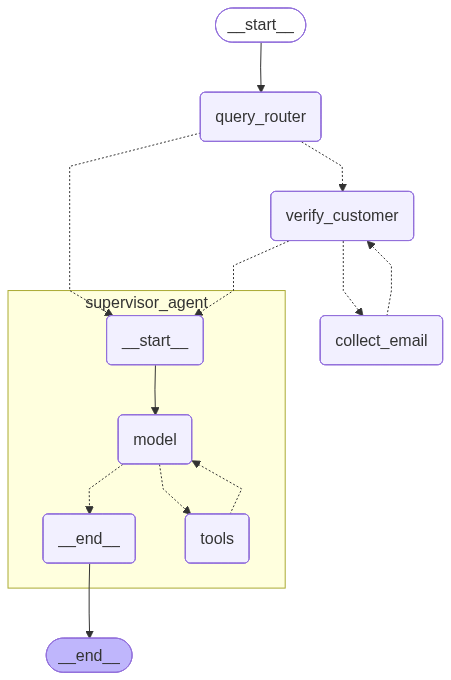

In [51]:
from IPython.display import Image

display(Image(verification_graph.get_graph(xray=True).draw_mermaid_png()))

## Test the Verification Graph

Let's test all four scenarios:
1. **General query** - No verification needed
2. **Personal query** - Verification with successful email
3. **Personal query with retry** - Invalid email, then valid email
4. **Follow-up query** - Verification skipped (already verified in thread)

### Scenario 1: General Query (No HITL)

Queries about products or policies don't need customer identity verification.

In [15]:
import uuid

thread_id_1 = str(uuid.uuid4())
config_1 = {"configurable": {"thread_id": thread_id_1}}

result = verification_graph.invoke(
    {"messages": [HumanMessage(content="how much does the Apple Magic Mouse cost?")]},
    config=config_1,
)

for msg in result["messages"]:
    msg.pretty_print()

================================ Human Message =================================

how much does the Apple Magic Mouse cost?
================================== Ai Message ==================================

[{'id': 'toolu_01U1bmBzBoonGsAWqHAqs28n', 'input': {'query': 'What is the price of the Apple Magic Mouse?'}, 'name': 'database_specialist', 'type': 'tool_use'}]
Tool Calls:
  database_specialist (toolu_01U1bmBzBoonGsAWqHAqs28n)
 Call ID: toolu_01U1bmBzBoonGsAWqHAqs28n
  Args:
    query: What is the price of the Apple Magic Mouse?
================================= Tool Message =================================
Name: database_specialist

The Apple Magic Mouse is priced at **$79.00** and is currently in stock.
================================== Ai Message ==================================

The Apple Magic Mouse costs **$79.00** and is currently in stock at TechHub if you'd like to purchase one!


### Scenario 2: Personal Query with Successful Verification

Queries about "my orders" require identity verification.

**Test email:** `sarah.chen@gmail.com` (exists in database)

In [42]:
# New thread
thread_id_2 = str(uuid.uuid4())
config_2 = {"configurable": {"thread_id": thread_id_2}}

# First invocation - will pause at interrupt
result = verification_graph.invoke(
    {"messages": [HumanMessage(content="Whats the status of my recent order?")]},
    config=config_2,
)

result

{'messages': [HumanMessage(content='Whats the status of my recent order?', additional_kwargs={}, response_metadata={}, id='38483279-4db0-4c2b-a309-91e57db392bc'),
  AIMessage(content='To access information about your account or orders, please provide your email address.', additional_kwargs={}, response_metadata={}, id='2c1a37f7-aab2-4680-a903-7cc7ca1952b0')],
 '__interrupt__': [Interrupt(value='Please provide your email:', id='f7e173efcdbe3af0fcef90a3ed6b8895')]}

In [43]:
# Resume with valid email
result = verification_graph.invoke(
    Command(resume="Ok, its: sarah.chen@gmail.com"), config=config_2
)
result

{'messages': [HumanMessage(content='Whats the status of my recent order?', additional_kwargs={}, response_metadata={}, id='38483279-4db0-4c2b-a309-91e57db392bc'),
  AIMessage(content='To access information about your account or orders, please provide your email address.', additional_kwargs={}, response_metadata={}, id='2c1a37f7-aab2-4680-a903-7cc7ca1952b0'),
  HumanMessage(content='Ok, its: sarah.chen@gmail.com', additional_kwargs={}, response_metadata={}, id='504a1c02-67b1-407d-9599-f31b04eb6ab8'),
  AIMessage(content='✓ Verified! Welcome back, Sarah Chen.', additional_kwargs={}, response_metadata={}, id='21c59542-8526-476e-8e7c-be8062f0bf13'),
  AIMessage(content=[{'text': '\n\nLet me check the status of your recent order.', 'type': 'text'}, {'id': 'toolu_01QLqS7k6jf67VrFbU7WEe8R', 'input': {'query': "What is the status of the customer's most recent order?"}, 'name': 'database_specialist', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01VFDqp861HvikhkD7RjS

In [44]:
for msg in result["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Whats the status of my recent order?
================================== Ai Message ==================================

To access information about your account or orders, please provide your email address.
================================ Human Message =================================

Ok, its: sarah.chen@gmail.com
================================== Ai Message ==================================

✓ Verified! Welcome back, Sarah Chen.
================================== Ai Message ==================================

[{'text': '\n\nLet me check the status of your recent order.', 'type': 'text'}, {'id': 'toolu_01QLqS7k6jf67VrFbU7WEe8R', 'input': {'query': "What is the status of the customer's most recent order?"}, 'name': 'database_specialist', 'type': 'tool_use'}]
Tool Calls:
  database_specialist (toolu_01QLqS7k6jf67VrFbU7WEe8R)
 Call ID: toolu_01QLqS7k6jf67VrFbU7WEe8R
  Args:
    query: What is the status 

### Scenario 3: Personal Query with Retry (Invalid Email)

What happens when the user provides an invalid email? The graph retries!

In [56]:
# New thread
thread_id_3 = str(uuid.uuid4())
config_3 = {"configurable": {"thread_id": thread_id_3}}


# First invocation - pauses
result = verification_graph.invoke(
    {"messages": [HumanMessage(content="Show me my recent purchases")]}, config=config_3
)
result

{'messages': [HumanMessage(content='Show me my recent purchases', additional_kwargs={}, response_metadata={}, id='dfe74c84-b41a-47a3-bc63-a8dd2cc9696b'),
  AIMessage(content='To access information about your account or orders, please provide your email address.', additional_kwargs={}, response_metadata={}, id='10f1895d-bf3f-48b6-a008-d375136a38dc')],
 '__interrupt__': [Interrupt(value='Please provide your email:', id='3d063f75f3eafea1c65693fac13b6f77')]}

In [57]:
# Resume with INVALID email (not in database)
result = verification_graph.invoke(Command(resume="wrong@email.com"), config=config_3)
result

{'messages': [HumanMessage(content='Show me my recent purchases', additional_kwargs={}, response_metadata={}, id='dfe74c84-b41a-47a3-bc63-a8dd2cc9696b'),
  AIMessage(content='To access information about your account or orders, please provide your email address.', additional_kwargs={}, response_metadata={}, id='10f1895d-bf3f-48b6-a008-d375136a38dc'),
  HumanMessage(content='wrong@email.com', additional_kwargs={}, response_metadata={}, id='39a1a414-fe57-4e2e-85a5-1f342a16ce01'),
  AIMessage(content="I couldn't find 'wrong@email.com' in our system. Please check and try again.", additional_kwargs={}, response_metadata={}, id='dc30fadc-8b54-46fb-9bf0-84b61e83a455')],
 '__interrupt__': [Interrupt(value='Please provide your email:', id='e5a74bd13086d36d104be7d5b6e8a95f')]}

In [58]:
# Resume with VALID email
result = verification_graph.invoke(
    Command(resume="Ah sorry its actually sarah.chen@gmail.com"), config=config_3
)
result

{'messages': [HumanMessage(content='Show me my recent purchases', additional_kwargs={}, response_metadata={}, id='dfe74c84-b41a-47a3-bc63-a8dd2cc9696b'),
  AIMessage(content='To access information about your account or orders, please provide your email address.', additional_kwargs={}, response_metadata={}, id='10f1895d-bf3f-48b6-a008-d375136a38dc'),
  HumanMessage(content='wrong@email.com', additional_kwargs={}, response_metadata={}, id='39a1a414-fe57-4e2e-85a5-1f342a16ce01'),
  AIMessage(content="I couldn't find 'wrong@email.com' in our system. Please check and try again.", additional_kwargs={}, response_metadata={}, id='dc30fadc-8b54-46fb-9bf0-84b61e83a455'),
  HumanMessage(content='Ah sorry its actually sarah.chen@gmail.com', additional_kwargs={}, response_metadata={}, id='528385b2-34c2-4ce4-bcfd-abdff9976c1a'),
  AIMessage(content='✓ Verified! Welcome back, Sarah Chen.', additional_kwargs={}, response_metadata={}, id='db799612-fdc4-48f7-82e3-cba02e5b2a42'),
  AIMessage(content=[{'t

In [59]:
for msg in result["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Show me my recent purchases
================================== Ai Message ==================================

To access information about your account or orders, please provide your email address.
================================ Human Message =================================

wrong@email.com
================================== Ai Message ==================================

I couldn't find 'wrong@email.com' in our system. Please check and try again.
================================ Human Message =================================

Ah sorry its actually sarah.chen@gmail.com
================================== Ai Message ==================================

✓ Verified! Welcome back, Sarah Chen.
================================== Ai Message ==================================

[{'text': '\n\nNow let me retrieve your recent purchases for you.', 'type': 'text'}, {'id': 'toolu_015neQ988HxpeVVaxYwKtW5o', 'input': {'

### Scenario 4: Follow-up Query (Skip Verification)

Once verified in a thread, follow-up queries skip verification entirely!

In [60]:
# Use the same thread from Scenario 3 (already verified)

result = verification_graph.invoke(
    {
        "messages": [
            HumanMessage(content="What exactly was in my most expensive order?")
        ]
    },
    config=config_3,  # Reuse config from Scenario 3
)

result["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your most expensive order, **ORD-2024-0077** ($3,125.00), contained 5 items:

1. **TECH-AUD-016** - $399.00
2. **TECH-ACC-024** - $29.00
3. **TECH-KEY-010** - $99.00
4. **TECH-LAP-001** - $1,199.00
5. **TECH-LAP-003** - $1,399.00

It looks like you purchased two laptops along with some accessories and audio equipment. Would you like me to get the specific product names and details for any of these items?


## Key Takeaways

### LangGraph Primitives Demonstrated

1. **StateGraph** - Custom state schema with domain-specific fields
   - `messages`: Shared with supervisor subgraph (uses `add_messages` reducer)
   - `customer_id`: Verification status (set after successful email validation)

2. **Nodes** - Modular functions that operate on state
   - `query_router`: Routes based on verification needs (checks state + classifies query)
   - `verify_customer`: Extracts email using structured output & validates against database
   - `collect_email`: Dedicated HITL node with `interrupt()`
   - `supervisor_agent`: Subgraph node (compiled graph from Section 3)

3. **Command for Explicit Routing** - Nodes control their own flow
   ```python
   def verify_customer(state):
       if success:
           return Command(update={...}, goto="supervisor_agent")
       else:
           return Command(update={...}, goto="collect_email")
   ```
   **Benefit:** Routing logic is co-located with business logic - easier to understand!

4. **interrupt()** - Pause execution for human input
   - Best practice: Use dedicated node for `interrupt()`
   - Separate HITL logic from business logic
   - Requires checkpointer to work

5. **Checkpointer** - State persistence across turns
   - Required for `interrupt()` to work
   - Enables conversation memory
   - Automatically propagated to subgraphs

6. **Subgraphs** - Compose graphs as nodes
   - Reuse Section 3's supervisor as a node
   - Shared state keys (`messages`)
   - Clean separation of concerns

### When to Use What

| Pattern | Use When... |
|---------|-------------|
| **`create_agent`** | Simple agents, standard tool loops, straightforward routing |
| **LangGraph StateGraph** | Conditional HITL, custom state, complex orchestration, retry loops |
| **Hybrid (this section!)** | Keep agents simple, add sophisticated orchestration layer |
